**Question - 9**
--

**Part - 1**
- Load the Fashion MNIST dataset; split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. Note: for large images, you could use tf.io.encode_jpeg() instead. This would save a lot of space, but it would lose a bit of image quality. 

**Part - 2**
- Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [1]:
from tensorflow.train import Int64List, BytesList, Feature, Features, Example
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
from contextlib import ExitStack
from pathlib import Path
import numpy as np

2024-07-27 07:31:50.439311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 07:31:50.439462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 07:31:50.574055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Loading the MNIST Dataset**
--

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
print(type(fashion_mnist))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'tuple'>


In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


**Creating the Validation Split**
--

In [4]:
X_valid, y_valid = X_train[:8000], y_train[:8000]
X_train, y_train = X_train[8000:], y_train[8000:]

for name, _ in [["X_train", X_train], ["y_train", y_train], 
                ["X_valid", X_valid], ["y_valid", y_valid], 
                ["X_test", X_test], ["y_test", y_test]]:
    print(name, _.shape)

X_train (52000, 28, 28)
y_train (52000,)
X_valid (8000, 28, 28)
y_valid (8000,)
X_test (10000, 28, 28)
y_test (10000,)


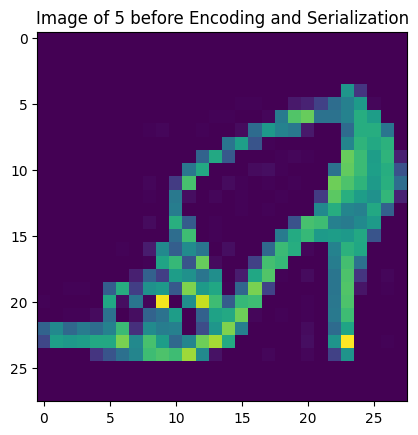

In [5]:
plt.imshow(X_train[0])
plt.title(f"Image of {y_train[0]} before Encoding and Serialization")
plt.show()

**Creating datasets from TensorSlices**
--

In [6]:
# Creating and Shuffling the TensorSlice Dataset used for training
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="TrainingSet")
train_set = train_set.shuffle(10_000, seed=17)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid), name="ValidationSet")
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="TestingSet")

**Saving the Dataset into multiple serialized Example Protocol Buffers**
--

In [7]:
def serialize_instance(img, label):
    
    # Encoding the Image
    serialized_img = tf.io.serialize_tensor(img)
    
    # Returning as an Example Protocol Buffer
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[serialized_img.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

# Verification
for img, label in train_set.take(1):
    print(serialize_instance(img, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\002+:TX0\000\000\000\000\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\035\306\367\337\336\336\343\344\351\255\027\000\000\001\000\000\000\000\000\000\000\000\000\000\000\004\0007\353\353\271\260\312\314\320\332\317\357\3666\000\005\000\000\000\000\000\000\000\000\000\000\000\002\000\216\376\341\317\377\377\376\372\375\251\343\354H\000\002\001\000\000\000\000\000\000\000\000\000\001\000\000\251\334\342\210\306\304\307\344\377\233\342\244m\000\000\000\000\000\000\000\000\000\000\000\002\000\000~\311\344\353\345\273\343\335\374\371\254\260\244\265\236\027\000\002\000\000\000\000\000\000\000\000\000\236\307\255\265\336\365\364\347\356\375\253\301\251\225\200\235\202\000\001\000\000\000\000\000\000\000\000\014\307\265\267\262\255\303\350\351\335\277\265\254\234\211\204\205\236\010\000\

**Utilizing the Naive Approach**
--

- Saving the Dataset Splits into Multiple Serialized TFRecords without any additional shuffling.
- Creating a New Dataset by interleaving all the TFRecords corresponding to each split.

In [8]:
def set_to_record(name, set_, n_parts=10):
    
    # Splitting the Indices into Chucks for storage as TFRecords
    indices = np.arange(len(set_[0]))
    chunks = np.array_split(indices, n_parts) 
    
    # Creating the Storage Path
    storage_path = Path() / "naive"
    storage_path.mkdir(parents=True, exist_ok=True)
    
    # File name format for all the files
    file_format = "{}-set-{:02d}.tfrecord"
    
    compression_op = tf.io.TFRecordOptions(compression_type="GZIP")
    file_paths = []
    for idx, chunk in enumerate(chunks):
        file_path = str(storage_path / file_format.format(name, idx))
        file_paths.append(file_path)
        
        with tf.io.TFRecordWriter(file_path, compression_op) as tfrecord:
            for instance in chunk:
                serialized = serialize_instance(set_[0][instance], set_[1][instance])
                tfrecord.write(serialized.SerializeToString())
    
    return file_paths

# Verification
ex_file_paths = set_to_record("Training", (X_train, y_train))
ex_file_paths

# Used for testing the Indices from the np.array_split()
# for instance in chunk:
#     print("Instance: ", instance)
#     print("Len: ", len(chunk))
#     break 

['naive/Training-set-00.tfrecord',
 'naive/Training-set-01.tfrecord',
 'naive/Training-set-02.tfrecord',
 'naive/Training-set-03.tfrecord',
 'naive/Training-set-04.tfrecord',
 'naive/Training-set-05.tfrecord',
 'naive/Training-set-06.tfrecord',
 'naive/Training-set-07.tfrecord',
 'naive/Training-set-08.tfrecord',
 'naive/Training-set-09.tfrecord']

**Loading and Parsing the TFRecords**
--

Serialized Information before Parsing
tf.Tensor(b'\n\xc2\x06\n\xaf\x06\n\x05image\x12\xa5\x06\n\xa2\x06\n\x9f\x06\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x85\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x02\x00\x00\x11\x181[o\x8a\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x02\x00\x00\x04j\xb9\xc3``q\x9e\x8d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x04\x00\x00\x02\x00\x00\x07Y\x88

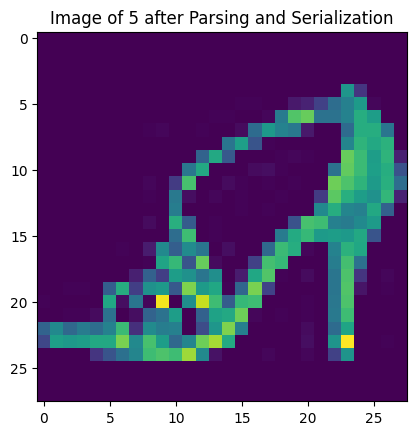

In [9]:
# Feature Description to Parse against the Serialized data in the protobuff
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
}

def parse_serialized_data(serialized_instance):
    # Step - 1: Remove the Serialization by Parsing the Feature Description
    encoded_image_data = tf.io.parse_single_example(serialized_instance, feature_description)
    
    # Step - 2: Decode the Encoded Image
    image_data = tf.io.parse_tensor(encoded_image_data["image"], out_type=tf.uint8)
    
    # Reshape and Return
    image = tf.reshape(image_data, shape=[28, 28])
    return image, encoded_image_data["label"]

# Verification
example_dataset = tf.data.TFRecordDataset(ex_file_paths[0], compression_type="GZIP")
instance = example_dataset.take(1)

print("Serialized Information before Parsing")
for i in instance:
    print(i)

print("\n\nSerialized Information after Parsing")
parsed_image = list(instance.map(parse_serialized_data))[0]
plt.imshow(parsed_image[0].numpy())
plt.title(f"Image of {parsed_image[1].numpy()} after Parsing and Serialization")
plt.show()

**Creating a well shuffled dataset loaded in Parallel**
--

In [10]:
def create_interleaved_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, 
                               n_parse_threads=5, batch_size=32, cache=False):
    
    # Creating the TFRecord Dataset containing Serialized Information
    serialized_dataset = tf.data.TFRecordDataset(
        filepaths, num_parallel_reads=n_read_threads, compression_type="GZIP"
    )
    
    # Caching the Data for better Efficiency
    if cache:
        serialized_dataset = serialized_dataset.cache()
        
    # Shuffling the Data
    if shuffle_buffer_size:
        serialized_dataset = serialized_dataset.shuffle(shuffle_buffer_size)
        
    # Parsing all the Serialzed Instances of the Dataset in Parallel
    dataset = serialized_dataset.map(parse_serialized_data, num_parallel_calls=n_parse_threads)
    
    # Batching and Prefetching the Dataset
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    '''# Batching and Prefetching
    dataset = dataset.batch(batch_size)
    for i in dataset.take(2):
        print(i)
        
    return dataset.prefetch(1)'''

# Verification
dataset = create_interleaved_dataset(filepaths=ex_file_paths, shuffle_buffer_size=10_000)
for i in dataset.take(2):
    print(i)

(<tf.Tensor: shape=(32, 28, 28), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0

**Applying the Naive Approach Completely**
--

In [11]:
# Training File Splits
train_filepaths = set_to_record("Training", (X_train, y_train), n_parts=20)
valid_filepaths = set_to_record("Validation", (X_valid, y_valid), n_parts=10)
test_filepaths = set_to_record("Testing", (X_test, y_test), n_parts=10)

print("Training Set Splits: \n", train_filepaths, end="\n\n")
print("Validation Set Splits: \n", valid_filepaths, end="\n\n")
print("Testing Set Splits: \n", test_filepaths)

Training Set Splits: 
 ['naive/Training-set-00.tfrecord', 'naive/Training-set-01.tfrecord', 'naive/Training-set-02.tfrecord', 'naive/Training-set-03.tfrecord', 'naive/Training-set-04.tfrecord', 'naive/Training-set-05.tfrecord', 'naive/Training-set-06.tfrecord', 'naive/Training-set-07.tfrecord', 'naive/Training-set-08.tfrecord', 'naive/Training-set-09.tfrecord', 'naive/Training-set-10.tfrecord', 'naive/Training-set-11.tfrecord', 'naive/Training-set-12.tfrecord', 'naive/Training-set-13.tfrecord', 'naive/Training-set-14.tfrecord', 'naive/Training-set-15.tfrecord', 'naive/Training-set-16.tfrecord', 'naive/Training-set-17.tfrecord', 'naive/Training-set-18.tfrecord', 'naive/Training-set-19.tfrecord']

Validation Set Splits: 
 ['naive/Validation-set-00.tfrecord', 'naive/Validation-set-01.tfrecord', 'naive/Validation-set-02.tfrecord', 'naive/Validation-set-03.tfrecord', 'naive/Validation-set-04.tfrecord', 'naive/Validation-set-05.tfrecord', 'naive/Validation-set-06.tfrecord', 'naive/Validation

In [12]:
# Prepared Sets
train_set = create_interleaved_dataset(
    filepaths=train_filepaths, shuffle_buffer_size=10_000, batch_size=64
)
print("Prepared Training Set Object: ", repr(train_set))

valid_set = create_interleaved_dataset(
    filepaths=valid_filepaths, shuffle_buffer_size=3000, cache=True, batch_size=64
)
print("Prepared Validation Set Object: ", repr(valid_set))

test_set = create_interleaved_dataset(
    filepaths=test_filepaths, shuffle_buffer_size=3000, cache=True, batch_size=64
)
print("Prepared Testing Set Object: ", repr(test_set))

Prepared Training Set Object:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Prepared Validation Set Object:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Prepared Testing Set Object:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [13]:
# Wrappers to avoid repetition
ConvLayer = partial(
    tf.keras.layers.Conv2D,
    kernel_size=(3, 3),
    activation="elu",
    kernel_initializer="he_normal"
)

DenseLayer = partial(
    tf.keras.layers.Dense,
    activation="elu",
    kernel_initializer="he_normal"
)

In [14]:
tf.keras.backend.clear_session()

simple_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    ConvLayer(filters=32),
    ConvLayer(filters=64),
    tf.keras.layers.MaxPool2D(2, 2),
    ConvLayer(filters=128),
    tf.keras.layers.Flatten(),
    DenseLayer(1024),
    DenseLayer(512),
    DenseLayer(512),
    DenseLayer(10, activation="softmax")
])

simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,993,482 (53.38 MB)

 Trainable params: 13,993,482 (53.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
exp_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2, decay_rate=0.1, decay_steps=10e3, staircase=False
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-3, restore_best_weights=True
)

simple_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Nadam(learning_rate=exp_lr_schedule)
)

simple_model.fit(
    train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping]
)

Epoch 1/30


2024-07-27 07:33:01.483145: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 676: 2.01985, expected 1.26858
2024-07-27 07:33:01.483234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 677: 2.17255, expected 1.42128
2024-07-27 07:33:01.483245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 678: 2.62646, expected 1.87519
2024-07-27 07:33:01.483254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 2.17504, expected 1.42377
2024-07-27 07:33:01.483263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 680: 2.46212, expected 1.71085
2024-07-27 07:33:01.483272: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 681: 2.56704, expected 1.81578
2024-07-27 07:33:01.483281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 682: 2.12676, expected 1.3755
2024-07-27 07:33:01.483290: E external/loc

     24/Unknown 7s 7ms/step - accuracy: 0.1839 - loss: 28159.6973

I0000 00:00:1722065584.286274      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722065584.310972      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    812/Unknown 13s 7ms/step - accuracy: 0.6932 - loss: 2012.1075

2024-07-27 07:33:10.451206: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.35363, expected 1.53764
2024-07-27 07:33:10.451293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.82107, expected 1.00508
2024-07-27 07:33:10.451304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.81936, expected 1.00338
2024-07-27 07:33:10.451314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.23827, expected 1.42229
2024-07-27 07:33:10.451323: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.05481, expected 2.23883
2024-07-27 07:33:10.451332: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.58554, expected 1.76955
2024-07-27 07:33:10.451341: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00002, expected 2.18403
2024-07-27 07:33:10.451350: E external/local_xla/xla/se

    813/Unknown 15s 10ms/step - accuracy: 0.6933 - loss: 2010.0474

W0000 00:00:1722065592.806464      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1722065593.605987      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


813/813 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6934 - loss: 2007.9922 - val_accuracy: 0.8174 - val_loss: 0.4994
Epoch 2/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8427 - loss: 0.4386 - val_accuracy: 0.8590 - val_loss: 0.4009
Epoch 3/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8665 - loss: 0.3621 - val_accuracy: 0.8270 - val_loss: 0.5167
Epoch 4/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8668 - loss: 0.3732 - val_accuracy: 0.8711 - val_loss: 0.3608
Epoch 5/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8923 - loss: 0.2950 - val_accuracy: 0.8558 - val_loss: 0.4436
Epoch 6/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5661 - loss: 660.2900 - val_accuracy: 0.1075 - val_loss: 2.3050
Epoch 7/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0981 - loss: 2.3068 - val_accuracy: 0.0934 - val_loss: 2.3064
Epoch 8/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.0984 - loss: 2.3071 - val_accuracy: 0.0990

In [16]:
simple_model.evaluate(test_set)

    141/Unknown 0s 3ms/step - accuracy: 0.8636 - loss: 0.3883

2024-07-27 07:34:08.246806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34972, expected 1.00161
2024-07-27 07:34:08.246886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.6774, expected 1.32929
2024-07-27 07:34:08.246903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.95868, expected 1.61057
2024-07-27 07:34:08.246919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.69333, expected 1.34521
2024-07-27 07:34:08.246934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.08558, expected 1.73747
2024-07-27 07:34:08.246946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.59326, expected 1.24515
2024-07-27 07:34:08.246959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.72639, expected 1.37827
2024-07-27 07:34:08.246970: E external/local_xla/xla/ser

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8640 - loss: 0.3879


W0000 00:00:1722065649.031820      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.38512590527534485, 0.8671000003814697]

**Utilizing the Alternate Approach**
--

- Saving all the splits into multiple TFRecord files by utilizing a Round-Robin approach to interleave each split while being saved as TFRecords.
- Rest of process remains the same.

In [17]:
# Creating and Shuffling the TensorSlice Dataset used for training
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="TrainingSet")
train_set = train_set.shuffle(10_000, seed=17)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid), name="ValidationSet")
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="TestingSet")

In [18]:
for img, label in valid_set.take(2):
    print(serialize_instance(img, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [19]:
def write_tfrecords_in_round_robin(name, dataset, n_shards=10):
    
    # New Storage path for TFRecords created using the Round Robin Approach
    storage_path = Path() / "alternate"
    storage_path.mkdir(parents=True, exist_ok=True)
    
    # List of all the filepaths
    paths = [str(storage_path / "{}.tfrecord-{:02d}-of-{:02d}".format(name, index, n_shards)) for index in range(n_shards)]
    
    # Maintaining multiple context writers
    with ExitStack() as stack:
        
        # Storing all the Writers to be used
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        
        for index, (img, label) in dataset.enumerate():
            
            # Finding the Shard to write the instance into
            shard = index % n_shards
            serialized = serialize_instance(img, label)
            writers[shard].write(serialized.SerializeToString())
            
    return paths

In [20]:
# Splitting all the datasets
train_paths = write_tfrecords_in_round_robin(
    name="TrainingSet", dataset=train_set
)
print("Training Paths:\n", train_paths)

valid_paths = write_tfrecords_in_round_robin(
    name="ValidationSet", dataset=valid_set
)
print("Validation Paths:\n", train_paths)

test_paths = write_tfrecords_in_round_robin(
    name="TestingSet", dataset=test_set
)
print("Testing Paths:\n", train_paths)

Training Paths:
 ['alternate/TrainingSet.tfrecord-00-of-10', 'alternate/TrainingSet.tfrecord-01-of-10', 'alternate/TrainingSet.tfrecord-02-of-10', 'alternate/TrainingSet.tfrecord-03-of-10', 'alternate/TrainingSet.tfrecord-04-of-10', 'alternate/TrainingSet.tfrecord-05-of-10', 'alternate/TrainingSet.tfrecord-06-of-10', 'alternate/TrainingSet.tfrecord-07-of-10', 'alternate/TrainingSet.tfrecord-08-of-10', 'alternate/TrainingSet.tfrecord-09-of-10']
Validation Paths:
 ['alternate/TrainingSet.tfrecord-00-of-10', 'alternate/TrainingSet.tfrecord-01-of-10', 'alternate/TrainingSet.tfrecord-02-of-10', 'alternate/TrainingSet.tfrecord-03-of-10', 'alternate/TrainingSet.tfrecord-04-of-10', 'alternate/TrainingSet.tfrecord-05-of-10', 'alternate/TrainingSet.tfrecord-06-of-10', 'alternate/TrainingSet.tfrecord-07-of-10', 'alternate/TrainingSet.tfrecord-08-of-10', 'alternate/TrainingSet.tfrecord-09-of-10']
Testing Paths:
 ['alternate/TrainingSet.tfrecord-00-of-10', 'alternate/TrainingSet.tfrecord-01-of-10',

**Preprocessing all the Sets**
--

In [21]:
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

def preprocess(tfrecord):
    
    # Step - 1: Parse the Serialized Information
    encoded_instance = tf.io.parse_single_example(tfrecord, feature_description)
    
    # Step - 2: Decoding the Tensor
    image_data = tf.io.parse_tensor(encoded_instance["image"], out_type=tf.uint8)
    
    # Step - 3: Reshaping the Tensor to an Image
    image = tf.reshape(image_data, shape=[28, 28])
    
    return image, encoded_instance["label"]

**Loading all the TFRecords in Parallel to create the datasets**
--

In [22]:
def create_dataset_from_filepaths(filepaths, n_read_threads=5, n_parse_threads=5, shuffle_buffer_size=None, batch_size=32, cache=None):
    
    # Creating a TFRecord Dataset from all the filepaths
    dataset = tf.data.TFRecordDataset(
        filenames=filepaths, num_parallel_reads=n_read_threads
    )
    
    # Caching if necessary
    if cache:
        dataset = dataset.cache()
        
    # Shuffling if necessary
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
        
    # Preprocessing
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    
    # Batching and Prefecting
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(5)

**Applying the Alternate Approach completely**
--

In [23]:
prepared_train_set = create_dataset_from_filepaths(
    filepaths=train_paths, 
    n_read_threads=tf.data.experimental.AUTOTUNE,
    n_parse_threads=tf.data.experimental.AUTOTUNE,
    shuffle_buffer_size=25000,
)
print("Prepared Training Set: ", prepared_train_set)

prepared_valid_set = create_dataset_from_filepaths(
    filepaths=valid_paths, 
    n_read_threads=tf.data.experimental.AUTOTUNE,
    n_parse_threads=tf.data.experimental.AUTOTUNE,
    shuffle_buffer_size=2000,
    cache=True
)
print("Prepared Validation Set: ", prepared_valid_set)

prepared_test_set = create_dataset_from_filepaths(
    filepaths=test_paths, 
    n_read_threads=tf.data.experimental.AUTOTUNE,
    n_parse_threads=tf.data.experimental.AUTOTUNE,
    shuffle_buffer_size=2000,
    cache=True
)
print("Prepared Testing Set: ", prepared_test_set)

Prepared Training Set:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Prepared Validation Set:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Prepared Testing Set:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [24]:
tf.keras.backend.clear_session()

# Standardization Layer
std_layer = tf.keras.layers.Normalization()

# Standardized Model
simple_std_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    std_layer,
    ConvLayer(128),
    ConvLayer(128),
    tf.keras.layers.MaxPooling2D(2, 2),
    ConvLayer(256),
    ConvLayer(256),
    tf.keras.layers.Flatten(),
    DenseLayer(1024),
    DenseLayer(1024),
    DenseLayer(1024),
    DenseLayer(512),
    DenseLayer(10, activation="softmax")
])

simple_std_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,441,485 (77.98 MB)

 Trainable params: 20,441,482 (77.98 MB)

 Non-trainable params: 3 (16.00 B)

In [25]:
exp_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=6e-3, decay_rate=0.1, decay_steps=10e3, staircase=False
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, min_delta=1e-4, patience=7
)

simple_std_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Nadam(learning_rate=exp_lr_schedule)
)

simple_std_model.fit(
    prepared_train_set, validation_data=prepared_valid_set, epochs=30, callbacks=[earlystop_cb]
)

Epoch 1/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.4926 - loss: 6762.5298 - val_accuracy: 0.7195 - val_loss: 0.7455
Epoch 2/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7477 - loss: 0.6525 - val_accuracy: 0.7972 - val_loss: 0.5263
Epoch 3/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7700 - loss: 0.7263 - val_accuracy: 0.1009 - val_loss: 2.3153
Epoch 4/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.0962 - loss: 2.3192 - val_accuracy: 0.0994 - val_loss: 2.3150
Epoch 5/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.1013 - loss: 2.3181 - val_accuracy: 0.1023 - val_loss: 2.3140
Epoch 6/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.1004 - loss: 2.3164 - val_accuracy: 0.0934 - val_loss: 2.3101
Epoch 7/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.0965 - loss: 2.3158 - val_accuracy: 0.1011 - val_loss: 2.3135
Epoch 8/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.100

In [26]:
simple_std_model.evaluate(prepared_test_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7935 - loss: 0.5337


[0.5589256286621094, 0.7864999771118164]